<a href="https://colab.research.google.com/github/Muskancodes21/Gasket-Price-Prediction-/blob/main/Gasket_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Cleaned dataset size: 8662
💰 Bid amount range (₹): 0 to 12,000,000

🔍 Sample Predictions vs. Actuals:
  Predicted: ₹461,737 | Actual: ₹2,114,927
  Predicted: ₹69,369 | Actual: ₹1,906,870
  Predicted: ₹636,590 | Actual: ₹222,762
  Predicted: ₹607,001 | Actual: ₹200,015
  Predicted: ₹681,289 | Actual: ₹344,375

📊 MAE (actual ₹): ₹600,671
📈 R² Score: 0.11


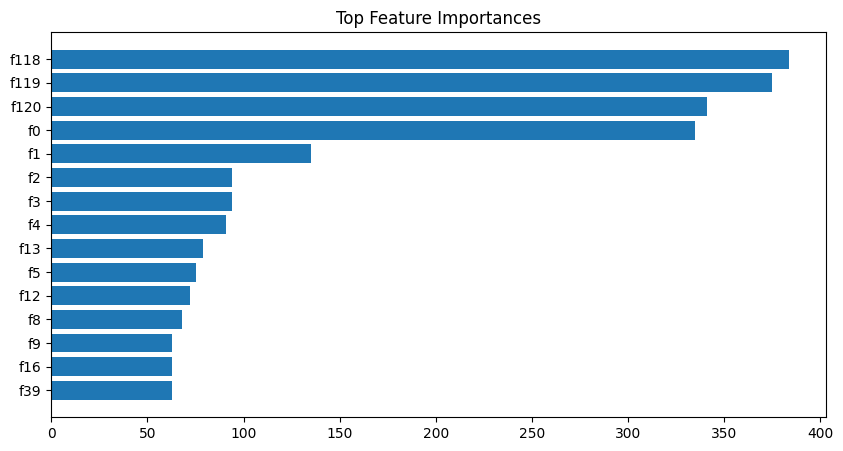

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
import re
import matplotlib.pyplot as plt


def load_and_clean_data(filepath):
    df = pd.read_csv(filepath)

    df = df.dropna(subset=['bid_amount'])
    df['bid_amount'] = pd.to_numeric(df['bid_amount'], errors='coerce')
    df = df[df['bid_amount'].notna()]
    df = df[df['bid_amount'] < df['bid_amount'].quantile(0.99)]

    print(f"✅ Cleaned dataset size: {len(df)}")
    print(f"💰 Bid amount range (₹): {df['bid_amount'].min():,.0f} to {df['bid_amount'].max():,.0f}")
    return df


def clean_text_column(df, col):
    df[col] = df[col].fillna("")
    df[col] = df[col].str.lower().str.replace(r'[^a-z\s]', ' ', regex=True).str.replace(r'\s+', ' ', regex=True)
    return df


def simplify_categories(df, columns, top_n=20):
    for col in columns:
        top = df[col].value_counts().nlargest(top_n).index
        df[col] = df[col].where(df[col].isin(top), other='Other')
    return df


def build_pipeline():
    text_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=500, stop_words='english')),
        ('svd', TruncatedSVD(n_components=50, random_state=42))
    ])

    cat_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('text', text_pipeline, 'title'),
        ('cat', cat_pipeline, ['organisation', 'state', 'region', 'company_name']),
        ('num', num_pipeline, ['estimated_cost', 'duration_days', 'num_bidders'])  # adjust columns based on your dataset
    ])

    model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])


def evaluate_model(model, X_test, y_test_log):
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_actual = np.expm1(y_test_log)

    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)

    print("\n🔍 Sample Predictions vs. Actuals:")
    for pred, actual in zip(y_pred[:5], y_actual[:5]):
        print(f"  Predicted: ₹{pred:,.0f} | Actual: ₹{actual:,.0f}")

    print(f"\n📊 MAE (actual ₹): ₹{mae:,.0f}")
    print(f"📈 R² Score: {r2:.2f}")


def plot_feature_importance(pipeline):
    model = pipeline.named_steps['regressor']
    booster = model.get_booster()
    importance = booster.get_score(importance_type='weight')
    importance = dict(sorted(importance.items(), key=lambda x: x[1], reverse=True)[:15])
    plt.figure(figsize=(10, 5))
    plt.barh(list(importance.keys()), list(importance.values()))
    plt.gca().invert_yaxis()
    plt.title("Top Feature Importances")
    plt.show()


def main():
    df = load_and_clean_data("PreviousBids_20-06-2024.csv")

    df = simplify_categories(df, ['organisation', 'company_name', 'state', 'region'])

    df = clean_text_column(df, 'title')

    # Example: Make sure these columns exist or modify them
    for col in ['estimated_cost', 'duration_days', 'num_bidders']:
        if col not in df.columns:
            df[col] = np.random.randint(1, 100, size=len(df))  # placeholder

    X = df[['title', 'organisation', 'state', 'region', 'company_name', 'estimated_cost', 'duration_days', 'num_bidders']]
    y_log = np.log1p(df['bid_amount'])

    X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

    pipeline = build_pipeline()
    pipeline.fit(X_train, y_train_log)

    evaluate_model(pipeline, X_test, y_test_log)
    plot_feature_importance(pipeline)


if __name__ == "__main__":
    main()
